# May 11-14,19, 2022: Idea1: don't care labels: create and train a model: Schaefer parcellation

Write your own `loss_function` to ignore padded time steps while computing loss and training/evaluating. 

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import tensorflow.keras.backend as K
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations, product
from operator import add
import copy

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/may22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
import helpers.base_model as base_model
import helpers.model_definitions as model_definitions
import data.emoprox2.scripts.stimulus_utils as stimulus_utils

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-05-20 15:33:07.743583: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-20 15:33:09.788502: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-20 15:33:09.795661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-20 15:33:09.795841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-20 15:33:09.795861: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

## training and testing datasets

In [2]:
def get_data(data, subject_list):
    X = [] 
    y = []
    Xlen = [] 
    global MASK

    for subject in subject_list:
        X += data[subject]['X']
        y += data[subject]['y']
        Xlen += [i.shape[0] for i in data[subject]['X']]

    X_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X, 
        padding="post",
        dtype='float', 
        value=MASK
    )
    
    y_padded = tf.keras.preprocessing.sequence.pad_sequences(
        y, 
        padding="post",
        dtype='float',
        value=MASK
    )
    # y_padded = tf.convert_to_tensor(y)

    return X_padded, y_padded, Xlen

In [4]:
'''
target stimuli
'''
APPR, RETR = 1, 0
MASK = 0.5

data_file = f"{proj_dir}/data/emoprox2/idea1_data_300ROIs.pkl"
with open(data_file, 'rb') as f:
    data = pickle.load(f)

'''
(hyper)-parameters
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data args
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

# model args
args.num_units = 32 #16 #32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.0 #0.8
args.learning_rate = 4e-4

args.num_epochs = 50
args.validation_split = 0.2
args.batch_size = 64

args.return_sequences = True

'''
generate dataset for the model
'''
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
 len_train) = get_data(data, train_list)
(X_test, y_test, 
 len_test) = get_data(data, test_list)

print(X_train.shape, y_train.shape)

(10154, 8, 300) (10154, 8)


## model: GRU

In [5]:
class CustomSCCE(tf.keras.losses.Loss):
    '''
    Custom Sparse Categorical Crossentropy
    '''
    def __init__(self, name='custom_scce'):
        super().__init__(name=name)
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )
    
    def call(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(y_true != MASK, tf.float32)
        loss *= mask
        # average on non-zeros
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [6]:
tf.random.set_seed(args.SEED)
regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_gruunits_{args.num_units}_idea1_300ROIs"
history_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_gruunits_{args.num_units}_idea1_300ROIs_history"

'''
build model
'''
model = model_definitions.get_GRU_classifier_model(
    X_train, 
    args, 
    regularizer, 
    mask_value=MASK, 
    return_sequences=True)

'''
compile model
'''
model.compile(
    loss=CustomSCCE(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

if os.path.exists(f"{model_file}.index"):
    '''
    load weights
    '''
    model.load_weights(model_file)
    history = json.load(open(f"{history_file}", 'r'))
else:
    '''
    train model
    '''
    then = time.time()
    history = model.fit(
        x=X_train, 
        y=y_train,
        batch_size=args.batch_size, 
        epochs=args.num_epochs, 
        verbose=1,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
        validation_split=args.validation_split, 
        shuffle=True)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    save model weights
    '''
    model.save_weights(model_file)
    history = history.history
    json.dump(history, open(f"{history_file}", 'w'))

# evaluate the model
eval_hist = model.evaluate(X_test, y_test)

2022-05-20 15:34:46.231081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 15:34:46.232910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-05-20 15:34:46.233362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-05-20 15:34:46.233425: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-20 15:34:46.616768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

Epoch 1/50


2022-05-20 15:34:49.295262: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-05-20 15:34:49.639881: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2022-05-20 15:34:49.759129: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-20 15:34:50.080233: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


127/127 [==============================] - 5s 16ms/step - loss: 1.6830 - sparse_categorical_accuracy: 0.5533 - val_loss: 1.2111 - val_sparse_categorical_accuracy: 0.5919
Epoch 2/50
127/127 [==============================] - 1s 11ms/step - loss: 0.9782 - sparse_categorical_accuracy: 0.6080 - val_loss: 0.8007 - val_sparse_categorical_accuracy: 0.6353
Epoch 3/50
127/127 [==============================] - 1s 11ms/step - loss: 0.7199 - sparse_categorical_accuracy: 0.6269 - val_loss: 0.6548 - val_sparse_categorical_accuracy: 0.6312
Epoch 4/50
127/127 [==============================] - 1s 11ms/step - loss: 0.6194 - sparse_categorical_accuracy: 0.6419 - val_loss: 0.5868 - val_sparse_categorical_accuracy: 0.6516
Epoch 5/50
127/127 [==============================] - 1s 11ms/step - loss: 0.5716 - sparse_categorical_accuracy: 0.6527 - val_loss: 0.5645 - val_sparse_categorical_accuracy: 0.6297
Epoch 6/50
127/127 [==============================] - 1s 11ms/step - loss: 0.5462 - sparse_categorical_acc

In [7]:
model.summary()

Model: "GRU_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 300)         0         
_________________________________________________________________
gru (GRU)                    (None, None, 32)          32064     
_________________________________________________________________
output (Dense)               (None, None, 2)           66        
Total params: 32,130
Trainable params: 32,130
Non-trainable params: 0
_________________________________________________________________


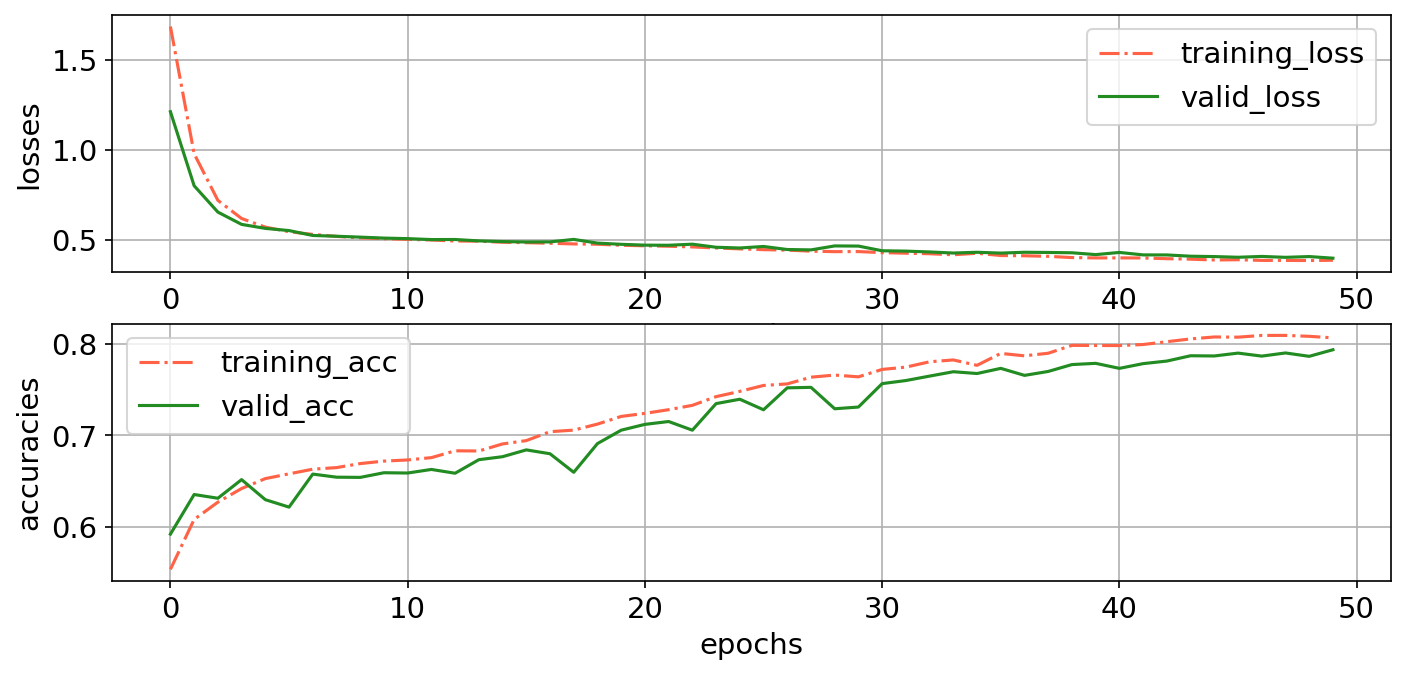

In [8]:
fig, axs = plt.subplots(
    nrows=2, ncols=1,
    figsize=(11,5),
    dpi=150
)

ax = axs[0]
ax.plot(history['loss'], color='tomato', linestyle='-.', label='training_loss')
ax.plot(history['val_loss'], color='forestgreen', label='valid_loss')
ax.set_ylabel(f"losses")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

ax = axs[1]
ax.plot(history['sparse_categorical_accuracy'], color='tomato', linestyle='-.', label='training_acc')
ax.plot(history['val_sparse_categorical_accuracy'], color='forestgreen', label='valid_acc')
ax.set_ylabel(f"accuracies")
ax.set_xlabel(f"epochs")
ax.legend()
ax.grid(True)

`training loss` is less than `validation loss`, and `training accuracy` is more than `validation loss`: **As expected**.

And `validation acc` closely follows `training acc`, which means: 
this means:
1. model is able to learn training data distribution and also generalize well on unseen data.
2. ???

Both accuracies are ~77%. 

Compare the performance with:
1. check how the model predicts and calculates accuracy,
1. models trained on null data,
2. train other models like multilayer perceptron (MLP), temporal convolutional network (tcn).

### 1. check evaluation metric.

evaluation metric seems okay. just that it also considers the masked timesteps. This is not a major concern currently. 

something is wrong; predictions flip midway in time within a sample, which it should not.
<!-- The concern is trained model predicts only the first label, i.e. `y_pred[:,0]`. `y_pred[:, 0] > 0.0 > y_pred[:, 1]`. **This is a serous concern!!**  -->

In [9]:
num_appr = np.sum(y_train[:, 0] == 1.0)
num_retr = np.sum(y_train[:, 0] == 0.0)
print(num_appr, num_retr)

y_pred = model(X_train)
print(y_pred[20:40, ...])
np.sum(np.equal(y_train, np.argmax(y_pred, axis=-1))) / (y_train.shape[0] * y_train.shape[1])

4553 5601
tf.Tensor(
[[[ 0.9755926  -1.4502045 ]
  [ 0.89112467 -1.4282395 ]
  [ 0.7582439  -1.3425264 ]
  [ 1.2755574  -2.0654597 ]
  [ 1.4269313  -2.2962363 ]
  [ 1.356502   -1.9721775 ]
  [ 1.2366025  -1.8510361 ]
  [ 0.06868865 -0.06868868]]

 [[ 0.51893395 -0.96074   ]
  [ 0.17035826 -0.9095067 ]
  [ 0.3017776  -1.1065141 ]
  [ 0.85748893 -1.7117146 ]
  [ 1.2673362  -2.2321637 ]
  [ 1.2458179  -2.1918511 ]
  [ 0.06868865 -0.06868868]
  [ 0.06868865 -0.06868868]]

 [[ 0.1637207  -0.50211644]
  [ 0.19270197 -0.7851943 ]
  [ 0.08142575 -0.83265334]
  [ 0.20178798 -1.0403296 ]
  [ 0.7434391  -1.6520565 ]
  [ 0.42605218 -1.3625842 ]
  [ 0.06868865 -0.06868868]
  [ 0.06868865 -0.06868868]]

 [[ 0.7702686  -1.1120456 ]
  [ 1.4295622  -1.9528244 ]
  [ 2.1518924  -2.7094662 ]
  [ 2.325962   -2.8909006 ]
  [ 1.9108615  -2.5680919 ]
  [ 1.2798123  -1.9625087 ]
  [ 0.06868865 -0.06868868]
  [ 0.06868865 -0.06868868]]

 [[ 0.0725093  -0.32637525]
  [ 0.08055687 -0.6105151 ]
  [-0.06446026 -0.6

0.6435518022454205

In [10]:
random_model = model_definitions.get_GRU_classifier_model(
    X_train,
    args,
    regularizer,
    mask_value=MASK,
    return_sequences=True
)
random_model.compile(
    loss=CustomSCCE(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
y_pred = random_model(X_train)
print(np.argmax(y_pred, axis=-1)[20:40, ...])
np.sum(np.equal(y_train, np.argmax(y_pred, axis=-1))) / (y_train.shape[0] * y_train.shape[1])

[[1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 0]
 [0 0 0 0 0 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 0 1 1 0]
 [0 0 1 1 1 1 1 0]
 [0 0 0 0 0 1 0 0]
 [1 1 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 1 1 1 1 1 0 0]]


0.37916092180421507

### 2. null datasets and null distribution of accuracies.

In [ ]:
num_null_models = 10
null_eval_hists_file = (
    f"{results_dir}/emoprox_full_data/models"
    f"/GRU_classifier_null_eval_hists_gruunits_{args.num_units}_idea1")
if not os.path.exists(null_eval_hists_file):
    null_eval_hists = []
    for idx_null in tqdm(np.arange(num_null_models)):
        # build, train, and save the model
        '''
        build model
        '''
        null_model = model_definitions.get_GRU_classifier_model(
            X_train, 
            args, 
            regularizer, 
            mask_value=MASK, 
            return_sequences=True
        )

        '''
        train model
        '''
        null_model.compile(
            loss=CustomSCCE(),
            optimizer=optimizer,
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )

        then = time.time()
        null_history = null_model.fit(
            x=X_train, 
            y=np.random.randint(low=0, high=2, size=(y_train.shape)).astype(float),
            batch_size=args.batch_size, 
            epochs=args.num_epochs, 
            verbose=1,
            callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
            validation_split=args.validation_split, 
            shuffle=True)
        print('--- train time =  %0.4f seconds ---' %(time.time() - then))

        # evaluate the model
        null_eval_hists.append(null_model.evaluate(X_test, y_test, verbose=0)[1])
    
    # save null evaluations
    with open(null_eval_hists_file, 'wb') as f:
        pickle.dump(null_eval_hists, f)
else:
    # load null evaluations
    with open(null_eval_hists_file, 'rb') as f:
        null_eval_hists = pickle.load(f) 

Text(0.5, 1.0, 'accuracy histograms of null models (blue) and actual model (red)')

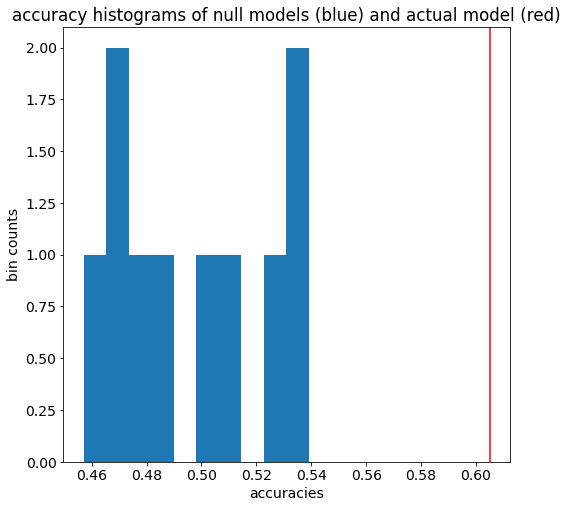

In [ ]:
plt.hist(np.stack(null_eval_hists, axis=0))
plt.axvline(eval_hist[1], color='red')
plt.xlabel('accuracies')
plt.ylabel('bin counts')
plt.title('accuracy histograms of null models (blue) and actual model (red)')

### 3. training other models

#### logistic regression

In [11]:
X = X_train
mask_value = MASK

tf.random.set_seed(args.SEED)
'''
build model
'''
inputs = tf.keras.Input(
    shape=(None, X.shape[-1]),
    name='input'
)
mask_layer = tf.keras.layers.Masking(
    mask_value=mask_value, 
    input_shape=[None, inputs.shape[-1]], 
    name='masking')
x = mask_layer(inputs)

intermediate_layer = tf.keras.layers.Dense(
    args.num_units,
    activation='relu'
)
x = intermediate_layer(x)

output_layer = tf.keras.layers.Dense(
        args.num_classes, 
        activation=None, 
        name='output')
outputs = output_layer(x)
log_reg = tf.keras.Model(inputs=inputs, outputs=outputs, name='logistic_regression')
'''
compile model
'''
log_reg.compile(
    loss=CustomSCCE(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

print(log_reg.summary())

'''
train model
'''
log_reg.fit(
    x=X_train, 
    y=y_train,
    batch_size=args.batch_size, 
    epochs=args.num_epochs, 
    verbose=1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
    validation_split=args.validation_split, 
    shuffle=True
)
'''
evaluate model
'''
eval_hist = log_reg.evaluate(X_test, y_test)

Model: "logistic_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 300)         0         
_________________________________________________________________
dense (Dense)                (None, None, 32)          9632      
_________________________________________________________________
output (Dense)               (None, None, 2)           66        
Total params: 9,698
Trainable params: 9,698
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
127/127 [==============================] - 1s 6ms/step - loss: 0.5335 - sparse_categorical_accuracy: 0.5865 - val_loss: 0.5118 - val_sparse_categorical_accuracy: 0.6245
Epoch 2/50
127/127 [==============================] - 1s 6

In [12]:
y_pred = log_reg(X_train)
print(y_pred[20:40, ...])

tf.Tensor(
[[[ 2.37325221e-01  3.99032533e-01]
  [-1.88867450e-01 -6.51739478e-01]
  [-2.07901984e-01 -3.49294767e-02]
  [ 4.84321028e-01  2.81416118e-01]
  [-4.03650224e-01 -3.25906515e-01]
  [-1.55573750e+00 -1.96739244e+00]
  [-1.24530840e+00 -1.67557096e+00]
  [ 2.89219111e-01 -4.81118500e-01]]

 [[ 3.41616660e-01 -4.87478852e-01]
  [ 1.80554166e-02 -2.38109499e-01]
  [ 2.67765522e-01 -5.56455195e-01]
  [ 9.41497535e-02 -1.47873247e+00]
  [ 1.74876183e-01 -6.03351712e-01]
  [-9.72843990e-02 -8.89508009e-01]
  [ 2.89219111e-01 -4.81118500e-01]
  [ 2.89219111e-01 -4.81118500e-01]]

 [[-4.10180211e-01 -6.67564690e-01]
  [-2.76157886e-01 -5.67993879e-01]
  [-3.93650949e-01 -4.03152049e-01]
  [-2.22675830e-01 -4.18836117e-01]
  [ 4.02354211e-01 -1.37721634e+00]
  [-1.67535365e-01 -2.10063994e-01]
  [ 2.89219111e-01 -4.81118500e-01]
  [ 2.89219111e-01 -4.81118500e-01]]

 [[-4.77475107e-01 -6.70724064e-02]
  [ 4.35340315e-01 -1.26568091e+00]
  [ 2.25879073e-01 -1.36863601e+00]
  [-8.40322

#### temporal convolutional network: tcn

In [13]:
args.num_filters = 32 # MAY NEED TO CHANGE
args.window_size = 4
args.strides = 1

In [14]:
X = X_train
mask_value = MASK

tf.random.set_seed(args.SEED)
'''
build model
'''
inputs = tf.keras.Input(
    shape=(None, X.shape[-1]),
    name='input'
)
mask_layer = tf.keras.layers.Masking(
    mask_value=mask_value, 
    input_shape=[None, inputs.shape[-1]], 
    name='masking')
x = mask_layer(inputs)

intermediate_layer = tf.keras.layers.Conv1D(
    filters=args.num_filters,
    kernel_size=args.window_size,
    strides=args.strides,
    padding='same', # MAY CHANGE TO `CAUSAL`/ `SAME`/ `VALID`
    activation='relu',
    name='conv'
)
x = intermediate_layer(x)

output_layer = tf.keras.layers.Dense(
        args.num_classes, 
        activation=None, 
        name='output')
outputs = output_layer(x)
tcn = tf.keras.Model(inputs=inputs, outputs=outputs, name='tcn')
'''
compile model
'''
tcn.compile(
    loss=CustomSCCE(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

print(tcn.summary())

'''
train model
'''
tcn.fit(
    x=X_train, 
    y=y_train,
    batch_size=args.batch_size, 
    epochs=args.num_epochs, 
    verbose=1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
    validation_split=args.validation_split, 
    shuffle=True
)
'''
evaluate model
'''
eval_hist = tcn.evaluate(X_test, y_test)

Model: "tcn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 300)         0         
_________________________________________________________________
conv (Conv1D)                (None, None, 32)          38432     
_________________________________________________________________
output (Dense)               (None, None, 2)           66        
Total params: 38,498
Trainable params: 38,498
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
127/127 [==============================] - 2s 7ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.5021 - val_loss: 0.5772 - val_sparse_categorical_accuracy: 0.5634
Epoch 2/50
127/127 [==============================] - 1s 6ms/step - loss

In [15]:
y_pred = tcn(X_train)
print(y_pred[20:40, ...])

tf.Tensor(
[[[-0.30307096 -2.2439132 ]
  [ 2.655159    1.0360124 ]
  [ 2.295221    0.4989503 ]
  [ 1.4549145   0.68451756]
  [ 0.91705924  0.22693451]
  [ 0.27265444  0.31080812]
  [-0.02066542 -0.71264315]
  [ 1.0193616  -3.8127732 ]]

 [[-0.8827161  -1.4843239 ]
  [ 2.9465318   1.1362886 ]
  [ 3.0870264   0.0807368 ]
  [ 2.9573855  -0.0519283 ]
  [ 2.523039   -1.1605659 ]
  [ 1.0009142  -1.2909404 ]
  [ 1.2557938  -3.2345374 ]
  [ 0.5979793  -0.9214518 ]]

 [[-0.5376643  -1.2655797 ]
  [-0.05213231 -1.5733801 ]
  [ 1.0587581  -1.4218364 ]
  [ 1.2369026  -0.17129804]
  [ 0.6569854   0.442146  ]
  [ 0.763687    0.08692934]
  [ 0.7127826  -1.7957344 ]
  [ 0.5979793  -0.9214518 ]]

 [[ 0.53196585 -2.899625  ]
  [ 0.42216322 -2.7960582 ]
  [ 0.7617233  -1.6103623 ]
  [ 0.2933509   0.10994925]
  [ 0.09802751  0.26928824]
  [ 0.24359226  0.28892148]
  [ 0.21849288 -2.9560978 ]
  [ 0.5979793  -0.9214518 ]]

 [[ 0.6779748  -0.9029135 ]
  [ 1.9410036   0.11434226]
  [ 2.6386473  -0.52067035]
 

#### Discussion:
<!-- Somehow all these models are stuck at 55% accuracy. **This points to how loss and accuracy are calculated.** -->